In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
os.chdir(os.path.join(os.getcwd(), '../..'))
print(os.getcwd())


/home/gus/workspaces/wpy/roya


In [7]:
%matplotlib inline
import datetime
import os
import seaborn as sns

import numpy as np
import pandas as pd
import sklearn.ensemble as skem
import sklearn.feature_selection as skselect
import sklearn.linear_model as skmod
import sklearn.metrics as skmet
import sklearn.svm as sksvm
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from plotnine import *
import recipes.exploratory_analysis as eda

print("All libraries loaded!!")


All libraries loaded!!


In [3]:
input_file = "resources/dataset/2015_2019_daily.pck"
output_folder = "report/"


# Lectura de datos
Tenemos los datos de las estaciones climatológicas de 2015 en adelante asociados a los datos de
campo en el fichero hd5 full_data.h5.


In [6]:
# read and clean data
df = pd.read_parquet(input_file)
df2 = pd.read_parquet('/home/gus/workspaces/wpy/roya/resources/dataset/2015_2019_daily_v2.pck')
df.head()

idest       date  event_per  event_per_skip  event_tot  event_tot_skip  \
14  47001 2015-01-02          0               0          0               0   
15  47002 2015-01-02          0               0          0               0   
16   9002 2015-01-02          0               0          0               0   
17  42101 2015-01-02          0               0          0               0   
18  42003 2015-01-02          0               0          0               0   

    temp_min  temp_mean  temp_median   temp_max  ...  prec_mean_10d_mean  \
14 -4.332031   0.039978    -1.435547   7.519531  ...            0.004147   
15 -4.093750   0.974121    -0.053467   9.046875  ...            0.000000   
16 -1.002930   3.476562     2.484375  10.257812  ...            0.000000   
17 -4.785156   1.725586     0.121033  12.609375  ...            0.000000   
18 -8.531250  -0.532227    -2.097656  12.687500  ...            0.000000   

    temp_mean_10d_max  hum_mean_10d_max  prec_mean_10d_max  detected_10d_sum  \
14           0.039978           87.1875           0.004147               0.0   
15           0.974121           78.5625           0.000000               0.0   
16           3.476562           64.8125           0.000000               0.0   
17           1.725586           64.6875           0.000000               0.0   
18          -0.532227           70.3125           0.000000               0.0   

    n_um_10d_sum      altitud  altitud_est  n_um  detected  
14           0.0   770.602051          748   0.0       0.0  
15           0.0   767.754761          793   0.0       0.0  
16           0.0   948.661926          975   0.0       0.0  
17           0.0  1041.646973         1043   0.0       0.0  
18           0.0  1091.197876         1063   0.0       0.0  

[5 rows x 59 columns]

In [5]:
df.columns

Index(['idest', 'date', 'event_per', 'event_per_skip', 'event_tot',
       'event_tot_skip', 'temp_min', 'temp_mean', 'temp_median', 'temp_max',
       'temp_std', 'hum_min', 'hum_mean', 'hum_median', 'hum_max', 'hum_std',
       'prec_min', 'prec_mean', 'prec_median', 'prec_max', 'prec_std',
       'prec_acum_30', 'prec_acum_60', 'dec_event_per', 'dec_event_per_skip',
       'dec_event_tot', 'dec_event_tot_skip', 'prec_acum_exp_30',
       'prec_acum_exp_60', 'perc_dec_event_tot_skip', 'yday', 'week', 'month',
       'year', 'prec_acum_30_porc', 'prec_acum_60_porc',
       'prec_acum_30_porc_sgm', 'month_sin', 'month_cos', 'week_sin',
       'week_cos', 'dyear', 'dyear_sin', 'dyear_cos', 'temp_mean_10d_min',
       'hum_mean_10d_min', 'prec_mean_10d_min', 'temp_mean_10d_mean',
       'hum_mean_10d_mean', 'prec_mean_10d_mean', 'temp_mean_10d_max',
       'hum_mean_10d_max', 'prec_mean_10d_max', 'detected_10d_sum',
       'n_um_10d_sum', 'altitud', 'altitud_est', 'n_um', 'detected'],
  

# EDA (Exploratory Data Analysis)


In [6]:
df = df.replace([np.inf, -np.inf], np.nan)

## comprobar que no hay columnas con datos NaN
df.columns[df.isna().any()].tolist()




[]

Imprimir el número de elementos detectados por estación y año

Creamos datatable agrupado por semana y estacion


In [10]:
# df_w = df[["idest","date","n_um","n_um_10d_sum","detected","detected_10d_sum"]].set_index(["date"]).groupby(['idest']).resample('W').sum()

# level_values = df.index.get_level_values
# df.groupby([level_values(i) for i in [0,1]] +[pd.Grouper(freq='2D', level=-1)]).sum()


df_w = df[["idest","date","n_um","n_um_10d_sum","detected","detected_10d_sum"]].set_index(["date","idest"]).groupby([pd.Grouper(level='idest'), 
                   pd.Grouper(level='date', freq='W')]).sum()

print(df_w.describe())
df_w.columns


               n_um  n_um_10d_sum      detected  detected_10d_sum
count  12889.000000  12889.000000  12889.000000      12889.000000
mean       1.891070     18.892855      0.089223          0.891458
std        5.803709     48.072365      0.871536          7.108710
min        0.000000      0.000000      0.000000          0.000000
25%        0.000000      0.000000      0.000000          0.000000
50%        0.000000      0.000000      0.000000          0.000000
75%        0.000000      0.000000      0.000000          0.000000
max       55.000000    555.000000     24.000000        294.000000


Index(['n_um', 'n_um_10d_sum', 'detected', 'detected_10d_sum'], dtype='object')

Visión general de número de unidades muestrales y número de detecciones por semana

In [11]:
print(df_w.shape)
print(df_w.index.get_level_values(1))


(12889, 4)
DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08',
               ...
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20',
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=12889, freq=None)


<AxesSubplot:xlabel='date', ylabel='detected'>

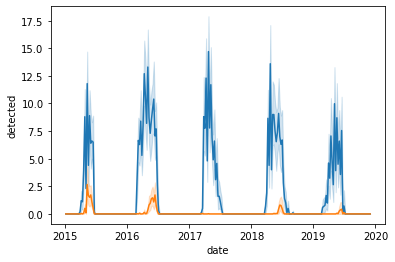

In [12]:
sns.lineplot(df_w.index.get_level_values(1),df_w.n_um)
sns.lineplot(df_w.index.get_level_values(1),df_w.detected)
# sns.lineplot(df_w.index[0],df_w.detected)


In [14]:
df_w.reset_index(inplace=True)
df_w["year"] = df_w.date.dt.year
df_w["week"] = df_w.date.dt.week

/home/gus/workspaces/wpy/venvs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


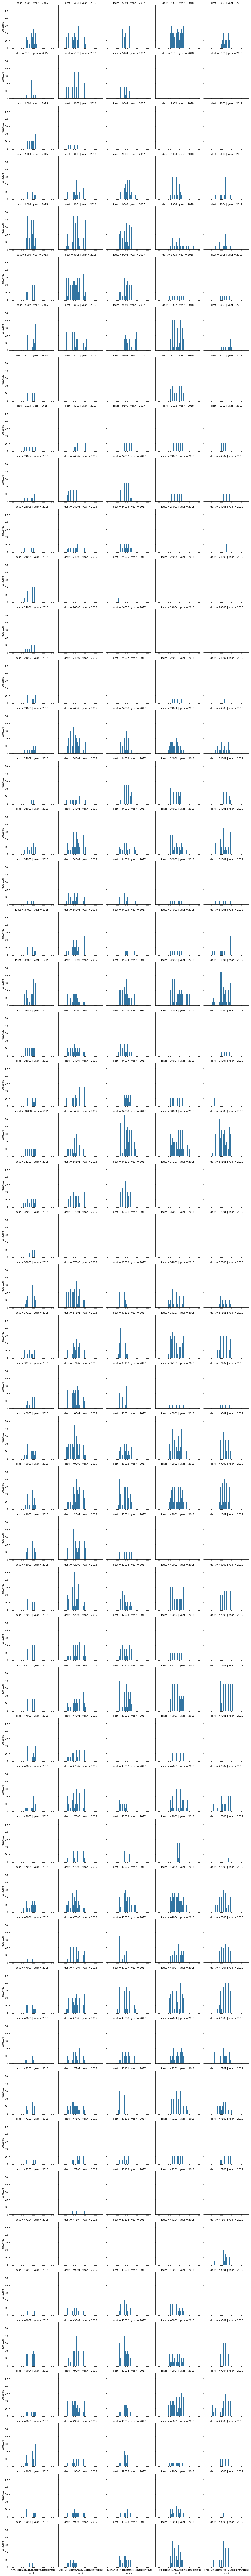

In [15]:

g = sns.FacetGrid(df_w, row="idest", col='year')
g.map_dataframe(sns.barplot, "week" ,"n_um")
g.map_dataframe(sns.barplot, "week" ,"detected")

# ubplots=True, color={"speed": "red", "lifespan": "green"}
# plt.show()

In [ ]:

(ggplot(df)
 + aes(x='week')
 +geom_bar(aes(y='pred'),color="blue")
 +geom_jitter(aes(y='gtrue'),color="green")
 +facet_grid("idest~ year")
#  +theme_matplotlib(rc={"figure.figsize": "80, 20"})
#  +theme_matplotlib(rc={"figure.figsize": "20, 20"})
)

In [ ]:
plt.show()

Comprobar si la toma de datos es homogénea por estación meteorológica

# Analizar correlación de datos
Imprimimos las matrices de correlación entre las variables del dataset.


In [ ]:
corr_matrix = eda.analyze_correlation(df, corr_method="spearman",
                                      output_file=os.path.join(output_folder, "corr_spearman.png"))



En el caso de variables dependientes categóricas con variables explicativas contínuas tenemos dos opciones
 para valorar la correlación:
* Si la variable categóricos es dicotómica podríamos utilizar el método de Point Biserial, pero impone 
restricciones fuertes en las variables explicativas contínuas, como que éstas sean normales, tendríamos que 
recurrir a algún tipo de transformación.
* La opción que nos queda es aplicar diferentes modelos de regresión logística incluyendo/eliminando 
diferentes variables y valorar la correlación en función de la capacidad predictiva del clasificador.

![Esquemas correlacion](images/correlation_options.png)


In [ ]:
# response variable classes balance
df["detectado"].hist()


Primera aproximación, entrenamos varios modelos y aplicamos validación
 cruzada sobre la métrica F1 para determinar si las variables X son buenas
  predictoras de la variable categórica "detectado".

Preprocesado de datos:
1. Filtramos columnas para quedarnos únicamene con eventos de la décaca
2. Normalizar y Standarizar dataset
3. Como las clases están desbalanceadas convertimos los datos para subrepresentar la clase mayoritaria (no-detectado) y aparte, agrupamos las categorías para tener únicamente dos clases (0,1)


In [ ]:
# treat DETECTADO as dicotomic variable
df.loc[df["detectado"] > 0, ["detectado"]] = 1

y_var = "detectado"
y = df[y_var]
exclude_cols = [y_var, "date", "zv", "idest"]
exclude_cols.extend([x for x in df.columns if (
    "temp_" in x) or ("hum_" in x) or ("prec_" in x)])
X = df.drop(exclude_cols, axis=1)
# normalizar y estandarizar
X = eda.normalize_data_sklearn(X)
X = eda.standardize_data_sklearn(X)
X_full = X.copy()
y_full = y.copy()
# undersampling de clase mayoritaria
cc = RandomUnderSampler(ratio="majority")
X_sampled, y_sampled = cc.fit_sample(X, y)
X = pd.DataFrame(X_sampled, columns=X.columns)
y = pd.Series(y_sampled)


Histograma de categorías resultantes

In [ ]:
plt.hist(y, bins="auto")


Entrenamos modelos más representativos utilizando validación cruzada y manteniendo la proporción de las clases en cada split de datos.
Cada modelo se entrena 10 veces y de cada entrenamiento obtenemos la medida de la métrica F1 para después
representar la distribución de la tasa de acierdo del clasificador con un boxplot.

In [ ]:
kfold = StratifiedKFold(n_splits=10)

models = [["LogRg", skmod.LogisticRegression()],
          # ["Lasso", skmod.Lasso()],
          ["Ridge", skmod.RidgeClassifier()],
          # ["PasAgr", skmod.PassiveAggressiveClassifier()],
          # ["kMeans", KNeighborsClassifier()],
          ["XTree", skem.ExtraTreesClassifier()],
          ["SVM-L", sksvm.LinearSVC()],
          # ["GausNB", GaussianNB()],
          # ["SVC-l", sksvm.SVC(kernel='linear')],
          # ["SVC-RBF", sksvm.SVC(kernel='rbf')]
          ]
# métrica F1-score para balancear error tipo I - Tipo 2
scoring = "f1"
summary = evalc.cross_val_summary_simple(
    models, X, y, scoring=scoring, options={"title": "Columnas de decadas"})

Entrenamos el modelo que mejor se comporta con el 
conjunto de datos completo separando de test/entrenamiento de forma aleatoria a un 30/70 y 
mostramos la matriz de confusión del clasificador resultante para valorar los errores tipo I y II.
Este sería el caso más optimista, los valores van a ser mayores que en el caso de la validación cruzada al utilizar todo el conjunto de datos.

In [ ]:
model = skem.ExtraTreesClassifier()
# metrics=["accuracy", "roc_auc"])
summary = evalc.cross_val_summary(models, X, y, metrics=["f1"])

X_train, X_test, Y_train, y_true = train_test_split(
    X, y, test_size=0.3, stratify=y)
model.fit(X_train, Y_train)
y_predicted = model.predict(X_test)

cmtx = skmet.confusion_matrix(y_true, y_predicted)
class_names = np.unique(y)
evalc.plot_confusion_matrix(
    cmtx, classes=class_names, normalize=True)


In [ ]:
report = skmet.classification_report(y_true, y_predicted)
# cálculo de f1 score en función de recall/precision
print(report)



Cargamos los datos completos y entrenamos un clasificador completo para compararlo con el caso balanceado, en este caso el clasificador tiene mejor valor de F1 general a costa de perder precisión y exhaustividad en la clase minoritaria (detectado = 1).

In [ ]:
model = skem.ExtraTreesClassifier()
# metrics=["accuracy", "roc_auc"])
X = X_full
y = y_full
summary = evalc.cross_val_summary(models, X, y, metrics=["f1"])

X_train, X_test, Y_train, y_true = train_test_split(
    X, y, test_size=0.3, stratify=y)
model.fit(X_train, Y_train)
y_predicted = model.predict(X_test)

cmtx = skmet.confusion_matrix(y_true, y_predicted)
class_names = np.unique(y)
evalc.plot_confusion_matrix(
    cmtx, classes=class_names, normalize=True)



In [ ]:
report = skmet.classification_report(y_true, y_predicted)
# cálculo de f1 score en función de recall/precision
print(report)
